In [66]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [257]:
#Configuring the IO structure:
W_size=3
st=4
et=22
Bin_size=1
prediction_size=1
n_features=282
irows=int(W_size/Bin_size)
icols=n_features
orows=int(prediction_size/Bin_size)
ocols=147
nipd=int((et-st)/Bin_size)-irows-orows+1

In [279]:
# Data Preparation
import pandas as pd

# Selecting data based on bin size
if Bin_size==0.5:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_30min.csv',header =None)
if Bin_size==1:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_1Hr.csv',header =None)
    
#Converting dataframe into matrix
dataset=df2.as_matrix()

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [280]:
#Checking if the import is good to go:
if len(dataset)-1==34*18/Bin_size:
    print("Import successful!")

Import successful!


In [281]:
print(irows,orows)

3 1


In [282]:
#Fixing number of clusters:
nclust=4

#Selecting correlated columns based on cluster number
if nclust==5:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Tree_5branch.csv',header =None)
if nclust==4:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Tree_4branch.csv',header =None)
if nclust==3:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Tree_3branch.csv',header =None)    
if nclust==2:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Tree_2branch.csv',header =None)
index_ps=df_clust[1]

#Creating a list of columns to consider for each model
cols2consider=[]
for i in range(nclust):
    cols2consider.append([])

#Appending values to cols2consider
for i in range(1,len(index_ps)):
    bloc=int(index_ps[i])
    cols2consider[bloc-1].append(i)
    
# Note: Here, in elements of cols2consider, segments start from 1 and go till 280.
# but while indexing in dataset, it should start from 0 therefore we subtract 1 
# from elements in cols2consider
c2c_copy=cols2consider
cols2consider=[]
for ar in c2c_copy:
    cols2consider.append([k-1 for k in ar])

if cols2consider[0]==[k-1 for k in c2c_copy[0]]:
    print("Unit Subraction from cols2consider complete! \n")
else:
    print("ERROR: Something wrong with subraction! \n")

#Check if everything is fine
index_l=index_ps.tolist()      # converting pandas series to list
if index_l.count('1')==len(cols2consider[0]) and (len(cols2consider[nclust-1])==index_l.count(str(nclust))):
    print("Good to go! Cols2consider seems good..")

Unit Subraction from cols2consider complete! 

Good to go! Cols2consider seems good..


In [324]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Create a list of X and y to put in X and y for different groups.
yl=[]
for i in range(nclust):
    yl.append([])
Xl=[]
for i in range(nclust):
    Xl.append([])

# Function to check a X,y pair and look at the lengths:
def verify_io(Xi,yi,info,i):
    if info==True:
        print("Number of X matrices:",len(Xi))
        print("Number of y matrices:",len(yi))
        print("Number i/o pairs expected:",(rows_pday-irows-orows+1)*34)
    elif(len(Xi)==len(yi)==(rows_pday-irows-orows+1)*34):
        print("Number of i/o pairs is as expected!")
    else:
        print("ERROR: Number of i/o pairs is not as expected!")
    if info==True:
        print("Number of features in each X matrix:",len(Xi[0][1]))
        print("Number of features in each y matrix:",len(yi[0]))
        print("Number of features expected:",len(cols2consider[i])+2,"for X")
    elif(len(Xi[0][1])-2==len(yi[0])==len(cols2consider[i])):
        print("Number of features is as expected!")
    else:
        print("ERROR: Number of features is not as expected!")

#Split sequences according to group number given:
def split_sequences_by_grp(sequences, n_steps_in, n_steps_out,grp_no): # Grp no should start from 0
    for i in range(len(sequences)):
        # Find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # Select columns depending on grouping and adding Weekday and Hour data
        ysel_col=[ji for ji in cols2consider[grp_no]]
        Xsel_col=[ja for ja in cols2consider[grp_no]]
        Xsel_col.append(280)
        Xsel_col.append(281)
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix,Xsel_col], sequences[end_ix:out_end_ix,ysel_col][0]
        Xl[grp_no].append(seq_x)
        yl[grp_no].append(seq_y)
    if len(seq_x[0])!= len(seq_y)+2:
        print("ERROR: column selection wrong!")
    return None

n_steps_in, n_steps_out = int(irows), int(orows)
rows_pday=int((et-st)/Bin_size)

# Convert into input/output
# Need to change to 34 or 35 or whatever when nrows in dataset change

for i in range(1,35):
    todays_df=dataset[(i-1)*rows_pday+1:i*rows_pday+1]
    for j in range(nclust):
        split_sequences_by_grp(todays_df, n_steps_in, n_steps_out,j)

#Check if the matrix are created properly:
verify_io(Xl[0],yl[0],False,0)
verify_io(Xl[1],yl[1],True,1)
verify_io(Xl[2],yl[2],False,2)
verify_io(Xl[3],yl[3],False,3)

Number of i/o pairs is as expected!
Number of features is as expected!
Number of X matrices: 510
Number of y matrices: 510
Number i/o pairs expected: 510
Number of features in each X matrix: 44
Number of features in each y matrix: 42
Number of features expected: 44 for X
Number of i/o pairs is as expected!
Number of features is as expected!
Number of i/o pairs is as expected!
Number of features is as expected!


In [325]:
#Filtering the Na IO matrices out
from math import isnan
import numpy as np

# #Function to check if all the NA matrices are deleted.
# def check_NA(X_fil,y_fil,Name):
#     Na_count=0
#     for i in range(len(X_fil)):
#         if np.any(np.isnan(y_fil[i]))==True & np.any(np.isnan(X_fil[i]))==True:
#             Na_count=Na_count+1
#     if Na_count==0:
#         print("Na Matrices filtered out sucessfuly in",Name,"!")
#     else:
#         print("ERROR: NA value found!")
        
#Function to filter the NA matrices.
def filter_NA(X_o,y_o):
    X_fil=np.array(X_o)
    y_fil=np.array(y_o)
    del_index=[]
    # Noting down the index of Na matrices in del_index 
    for i in range(len(X_fil)):
        del_index.append(np.any(np.isnan(X_fil[i])) or np.any(np.isnan(y_fil[i])))
    # Filtering out the Na matrices from y_fil and X_fil by indexing using a list
    y_fil=y_fil[list(~np.array(del_index))]
    X_fil=X_fil[list(~np.array(del_index))]
    return X_fil,y_fil


X1,y1=filter_NA(Xl[0],yl[0])
X2,y2=filter_NA(Xl[1],yl[1])
X3,y3=filter_NA(Xl[2],yl[2])
X4,y4=filter_NA(Xl[3],yl[3])

check_NA(X1,y1,"G1")
check_NA(X2,y2,"G2")
check_NA(X2,y2,"G3")
check_NA(X2,y2,"G4")

Na Matrices filtered out sucessfuly in G1 !
Na Matrices filtered out sucessfuly in G2 !
Na Matrices filtered out sucessfuly in G3 !
Na Matrices filtered out sucessfuly in G4 !


In [326]:
# Print number of IO Pairs available:
print(len(y4)," I/O pairs available")
verify_io(X1,y1,True,0)

289  I/O pairs available
Number of X matrices: 289
Number of y matrices: 289
Number i/o pairs expected: 510
Number of features in each X matrix: 70
Number of features in each y matrix: 68
Number of features expected: 70 for X


In [327]:
# Function to Flatten output
verify_io(Xl[0],yl[0],True,0)

# Note: No need to flatten output as y already has only 2 dimensions.
y1.shape
# def Flatten_output(y_il):
#     n_output = y_il.shape[1] * y_il.shape[2]
#     return y_il.reshape((y_il.shape[0], n_output))

# print(y1)
# y1=Flatten_output(y1)
# y2=Flatten_output(y2)
# y3=Flatten_output(y3)
# y4=Flatten_output(y4)

Number of X matrices: 510
Number of y matrices: 510
Number i/o pairs expected: 510
Number of features in each X matrix: 70
Number of features in each y matrix: 68
Number of features expected: 70 for X


(289, 68)

In [328]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [329]:
verify_io(X1,y1,True,0)
X1.shape

Number of X matrices: 289
Number of y matrices: 289
Number i/o pairs expected: 510
Number of features in each X matrix: 70
Number of features in each y matrix: 68
Number of features expected: 70 for X


(289, 3, 70)

In [330]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X1)) < 0.8
X_train = X1[msk]
y_train = y1[msk]
X_test = X1[~msk]
y_test = y1[~msk]
print("Dataset splitting done! for Grp-1")

#Verify shape once:
#verify_io(X_test,y_test,False,0)


n_output=len(y_train[0])
n_colx=len(X1[0][0])

# multivariate output multi-step 1d cnn example

# define model
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(500, activation='relu'))
model1.add(Dense(n_output))
model1.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model1.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-1 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model1.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model1.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model1.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-1
Group-1 ; Model-3 

Number or epochs: 12
Number of input features: 70
Number of output features: 68
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 230
Number of I/O pairs available for testing: 59
59/59 [==============================] - 0s 52us/step
Model Mape loss: 30.528160741773704
59/59 [==============================] - 0s 132us/step
Model MSE loss (Minimized): 191.20826255669027
59/59 [==============================] - 0s 85us/step
RMSE loss: 13.827807583152518


In [336]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X2)) < 0.8
X_train = X2[msk]
y_train = y2[msk]
X_test = X2[~msk]
y_test = y2[~msk]
print("Dataset splitting done! for Grp-2\n")

#Verify shape once:
verify_io(X_train,y_train,True,1)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dense(n_output))
model2.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model2.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-2 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model2.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model2.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model2.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-2

Number of X matrices: 230
Number of y matrices: 230
Number i/o pairs expected: 510
Number of features in each X matrix: 44
Number of features in each y matrix: 42
Number of features expected: 44 for X
Group-2 ; Model-3 

Number or epochs: 12
Number of input features: 44
Number of output features: 42
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 230
Number of I/O pairs available for testing: 59
59/59 [==============================] - 0s 93us/step
Model Mape loss: 10.938761387841176
59/59 [==============================] - 0s 149us/step
Model MSE loss (Minimized): 2.1290931661250228
59/59 [==============================] - 0s 233us/step
RMSE loss: 1.459141242692092


In [338]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X3)) < 0.8
X_train = X3[msk]
y_train = y3[msk]
X_test = X3[~msk]
y_test = y3[~msk]
print("Dataset splitting done! for Grp-3\n")

#Verify shape once:
verify_io(X_train,y_train,True,2)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model3 = Sequential()
model3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(500, activation='relu'))
model3.add(Dense(n_output))
model3.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model3.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-3 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model3.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model3.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model3.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-3

Number of X matrices: 230
Number of y matrices: 230
Number i/o pairs expected: 510
Number of features in each X matrix: 31
Number of features in each y matrix: 29
Number of features expected: 31 for X
Group-3 ; Model-3 

Number or epochs: 12
Number of input features: 31
Number of output features: 29
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 230
Number of I/O pairs available for testing: 59
59/59 [==============================] - 0s 51us/step
Model Mape loss: 41.52353972095554
59/59 [==============================] - 0s 82us/step
Model MSE loss (Minimized): 214.74492347846598
59/59 [==============================] - 0s 71us/step
RMSE loss: 14.654177680049672


In [340]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X4)) < 0.8
X_train = X4[msk]
y_train = y4[msk]
X_test = X4[~msk]
y_test = y4[~msk]
print("Dataset splitting done! for Grp-4\n")

#Verify shape once:
verify_io(X_train,y_train,True,3)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model4 = Sequential()
model4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(500, activation='relu'))
model4.add(Dense(n_output))
model4.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model4.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-4 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model4.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model4.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model4.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-4

Number of X matrices: 230
Number of y matrices: 230
Number i/o pairs expected: 510
Number of features in each X matrix: 143
Number of features in each y matrix: 141
Number of features expected: 143 for X
Group-4 ; Model-3 

Number or epochs: 12
Number of input features: 143
Number of output features: 141
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 230
Number of I/O pairs available for testing: 59
59/59 [==============================] - 0s 63us/step
Model Mape loss: 37.888189865370926
59/59 [==============================] - 0s 126us/step
Model MSE loss (Minimized): 160.1227437682071
59/59 [==============================] - 0s 131us/step
RMSE loss: 12.653961583954928


dict_keys(['val_loss', 'val_mean_absolute_percentage_error', 'loss', 'mean_absolute_percentage_error'])


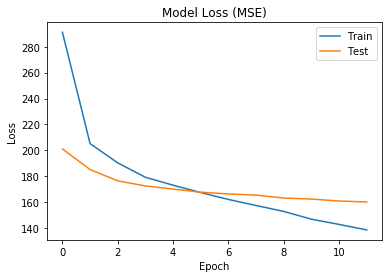

In [341]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#axes = plt.gca()
#axes.set_ylim([7500,0.2*100000])
#axes.set_xlim([1500,3000])
plt.show()

In [203]:
#history=model.fit(X, y, epochs=3000, verbose=1)
#model.evaluate(X,y)

In [393]:
# Plot a random Prediction vs actual travel time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(99)
rnd=np.random.randint(len(X_test))

# Define a function that returns the segment if a touple with (index in list,tt)
def tellme_seg(tu):
    return orderlist[tu[0]]

#Reshaping input to be suitable for the observation
x1_input = X1[~msk][rnd].reshape((1, 3, len(X1[0][0])))
x2_input = X2[~msk][rnd].reshape((1, 3, len(X2[0][0])))
x3_input = X3[~msk][rnd].reshape((1, 3, len(X3[0][0])))
x4_input = X4[~msk][rnd].reshape((1, 3, len(X4[0][0])))

#Predicting values for each group for rnd observation
g1_yp=model1.predict(x1_input, verbose=0)
g2_yp=model2.predict(x2_input, verbose=0)
g3_yp=model3.predict(x3_input, verbose=0)
g4_yp=model4.predict(x4_input, verbose=0)

#Getting the real value for each group for the rnd
g1_ya=y1[rnd]
g2_ya=y2[rnd]
g3_ya=y3[rnd]
g4_ya=y4[rnd]

orderlist=[]
tt_list_ya=list(g1_ya)+list(g2_ya)+list(g3_ya)+list(g4_ya)
tt_list_yp=list(g1_yp[0])+list(g2_yp[0])+list(g3_yp[0])+list(g4_yp[0])
for grp in cols2consider:
    orderlist=orderlist+grp

# Defining a function to map travel times to the
def arrange_tt_by_seg(tlist):
    touple_list=[(i,tlist[i]) for i in range(len(tlist))]
    touple_list.sort(key=tellme_seg)
    sorted_tp_list=touple_list
    arranged_tt=[el[1] for el in sorted_tp_list]
    return arranged_tt

act=arrange_tt_by_seg(tt_list_ya)
pdt=arrange_tt_by_seg(tt_list_yp)
#print(type(g1_ya.shape),"\n\n")
#print(len(yhat[0]))
# pdt=yhat[0]
# act=y_output
# if len(pdt)==len(act):
#     print("Lengths match good to go!")

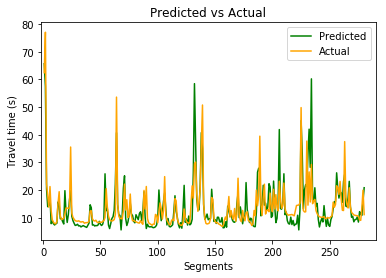

In [394]:
import matplotlib.pyplot as plt
import numpy

x=list(range(1,len(pdt)+1))
plt.plot(x, pdt[0:], color='g',label="Predicted")
plt.plot(x, act[0:], color='orange',label="Actual")
plt.xlabel('Segments')
plt.ylabel('Travel time (s)')
plt.title('Predicted vs Actual')
axes = plt.gca()
#axes.set_ylim([0,180])
axes.set_xlim([-2,len(pdt)+10])
leg = plt.legend();
#plt.show()